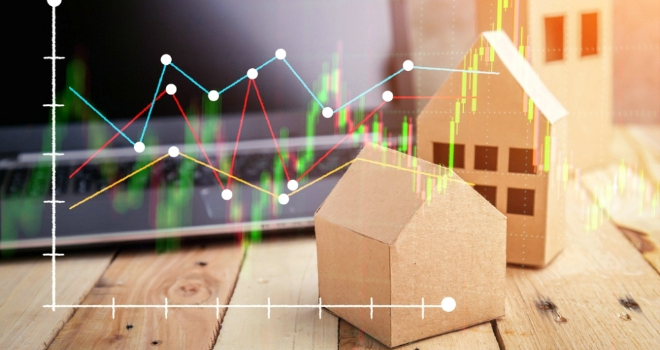

# > **Don't forget to upvote if you like my notebook. :)**

# **First step; import our library later read dataframes**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import seaborn as sb
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold,GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler,RobustScaler,LabelEncoder,PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
train=pd.read_csv('../HousePricePrediction/train.csv')
test=pd.read_csv('../HousePricePrediction/test.csv')
sample_sub=pd.read_csv('../HousePricePrediction/sample_submission.csv')

# **Variables associated with SalePrice**

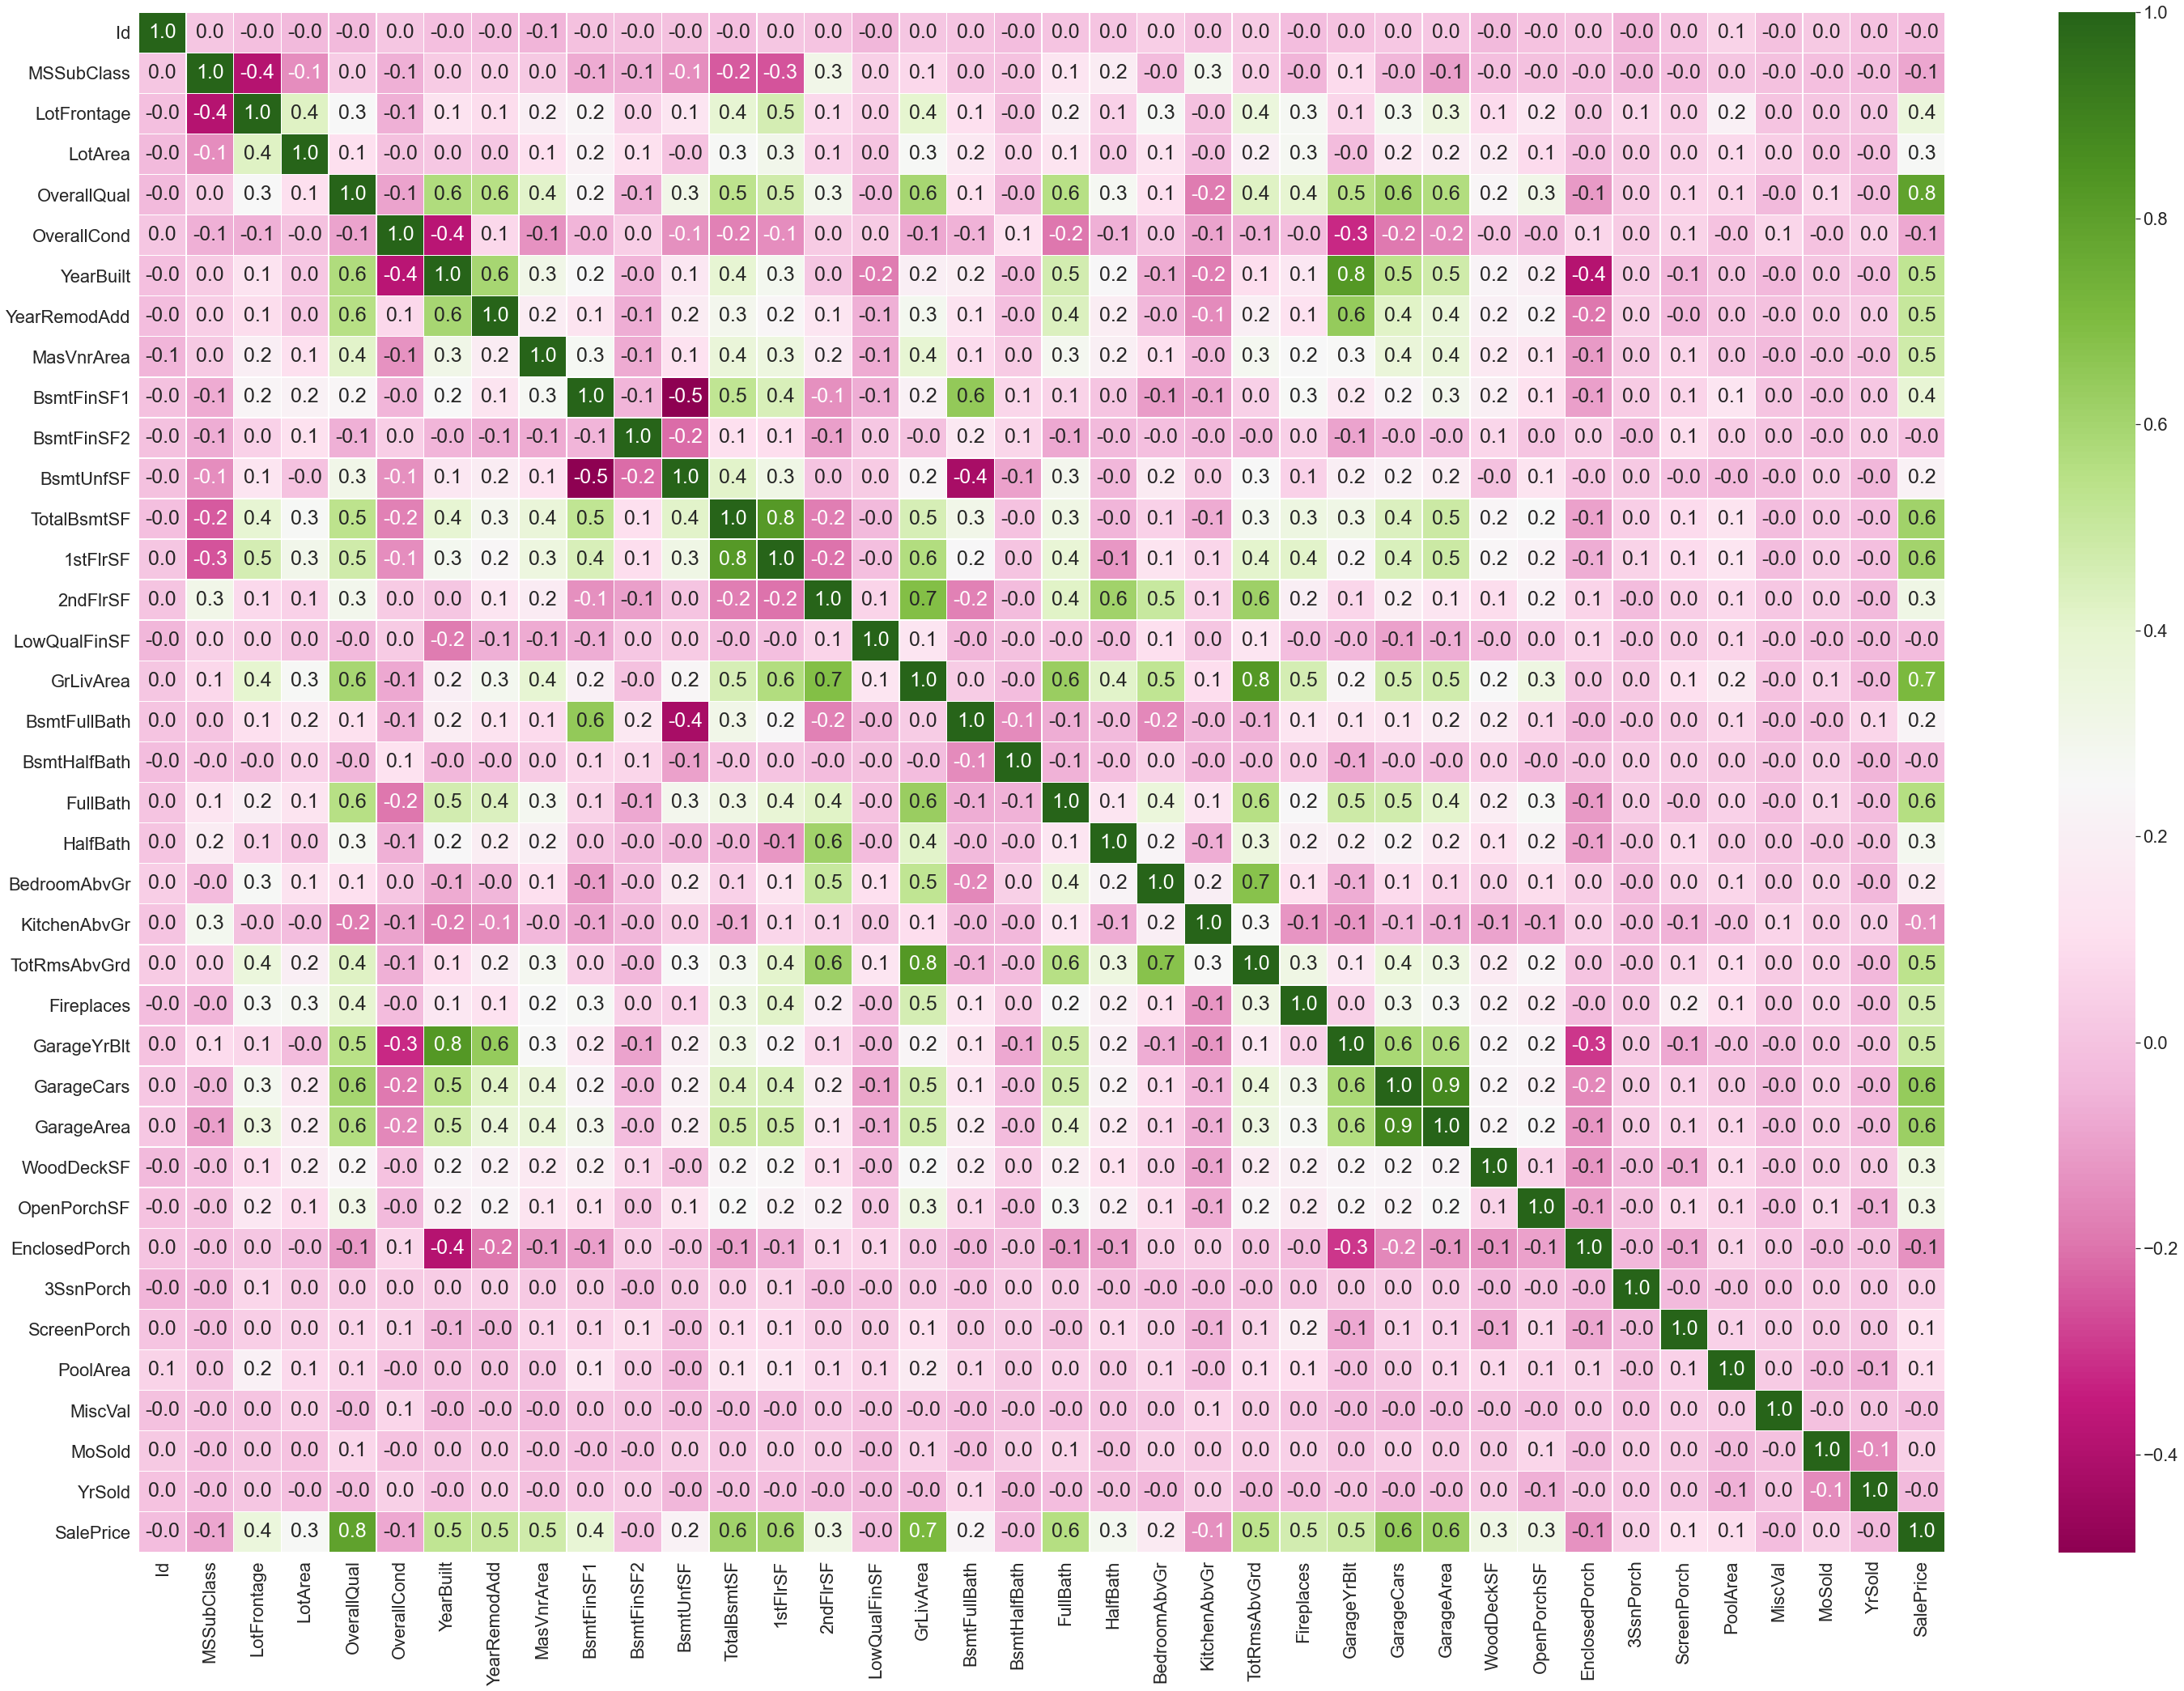

In [3]:
correlation_train=train.corr()
sb.set(font_scale=2)
plt.figure(figsize = (50,35))
ax = sb.heatmap(correlation_train, annot=True,annot_kws={"size": 25},fmt='.1f',cmap='PiYG', linewidths=.5)

In [4]:
corr_dict=correlation_train['SalePrice'].sort_values(ascending=False).to_dict()
important_columns=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<0.8)) | (value<=-0.1):
        important_columns.append(key)
important_columns

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'MasVnrArea',
 'Fireplaces',
 'BsmtFinSF1',
 'LotFrontage',
 'WoodDeckSF',
 '2ndFlrSF',
 'OpenPorchSF',
 'HalfBath',
 'LotArea',
 'BsmtFullBath',
 'BsmtUnfSF',
 'BedroomAbvGr',
 'ScreenPorch',
 'EnclosedPorch',
 'KitchenAbvGr']

# **In the visualization above, we can see the variables that affect SalePrice.**

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 [Text(0, 0, '1872'),
  Text(1, 0, '1875'),
  Text(2, 0, '1880'),
  Text(3, 0, '1882'),
  Text(4, 0, '1885'),
  Text(5, 0, '1890'),
  Text(6, 0, '1892'),
  Text(7, 0, '1893'),
  Text(8, 0, '1898'),
  Text(9, 0, '1900'),
  Text(10, 0, '1904'),
  Text(11, 0, '1905'),
  Text(12, 0, '1906'),
  Text(13, 0, '1908'),
  Text(14, 0, '1910'),
  Text(15, 0, '1911'),
  Text(1

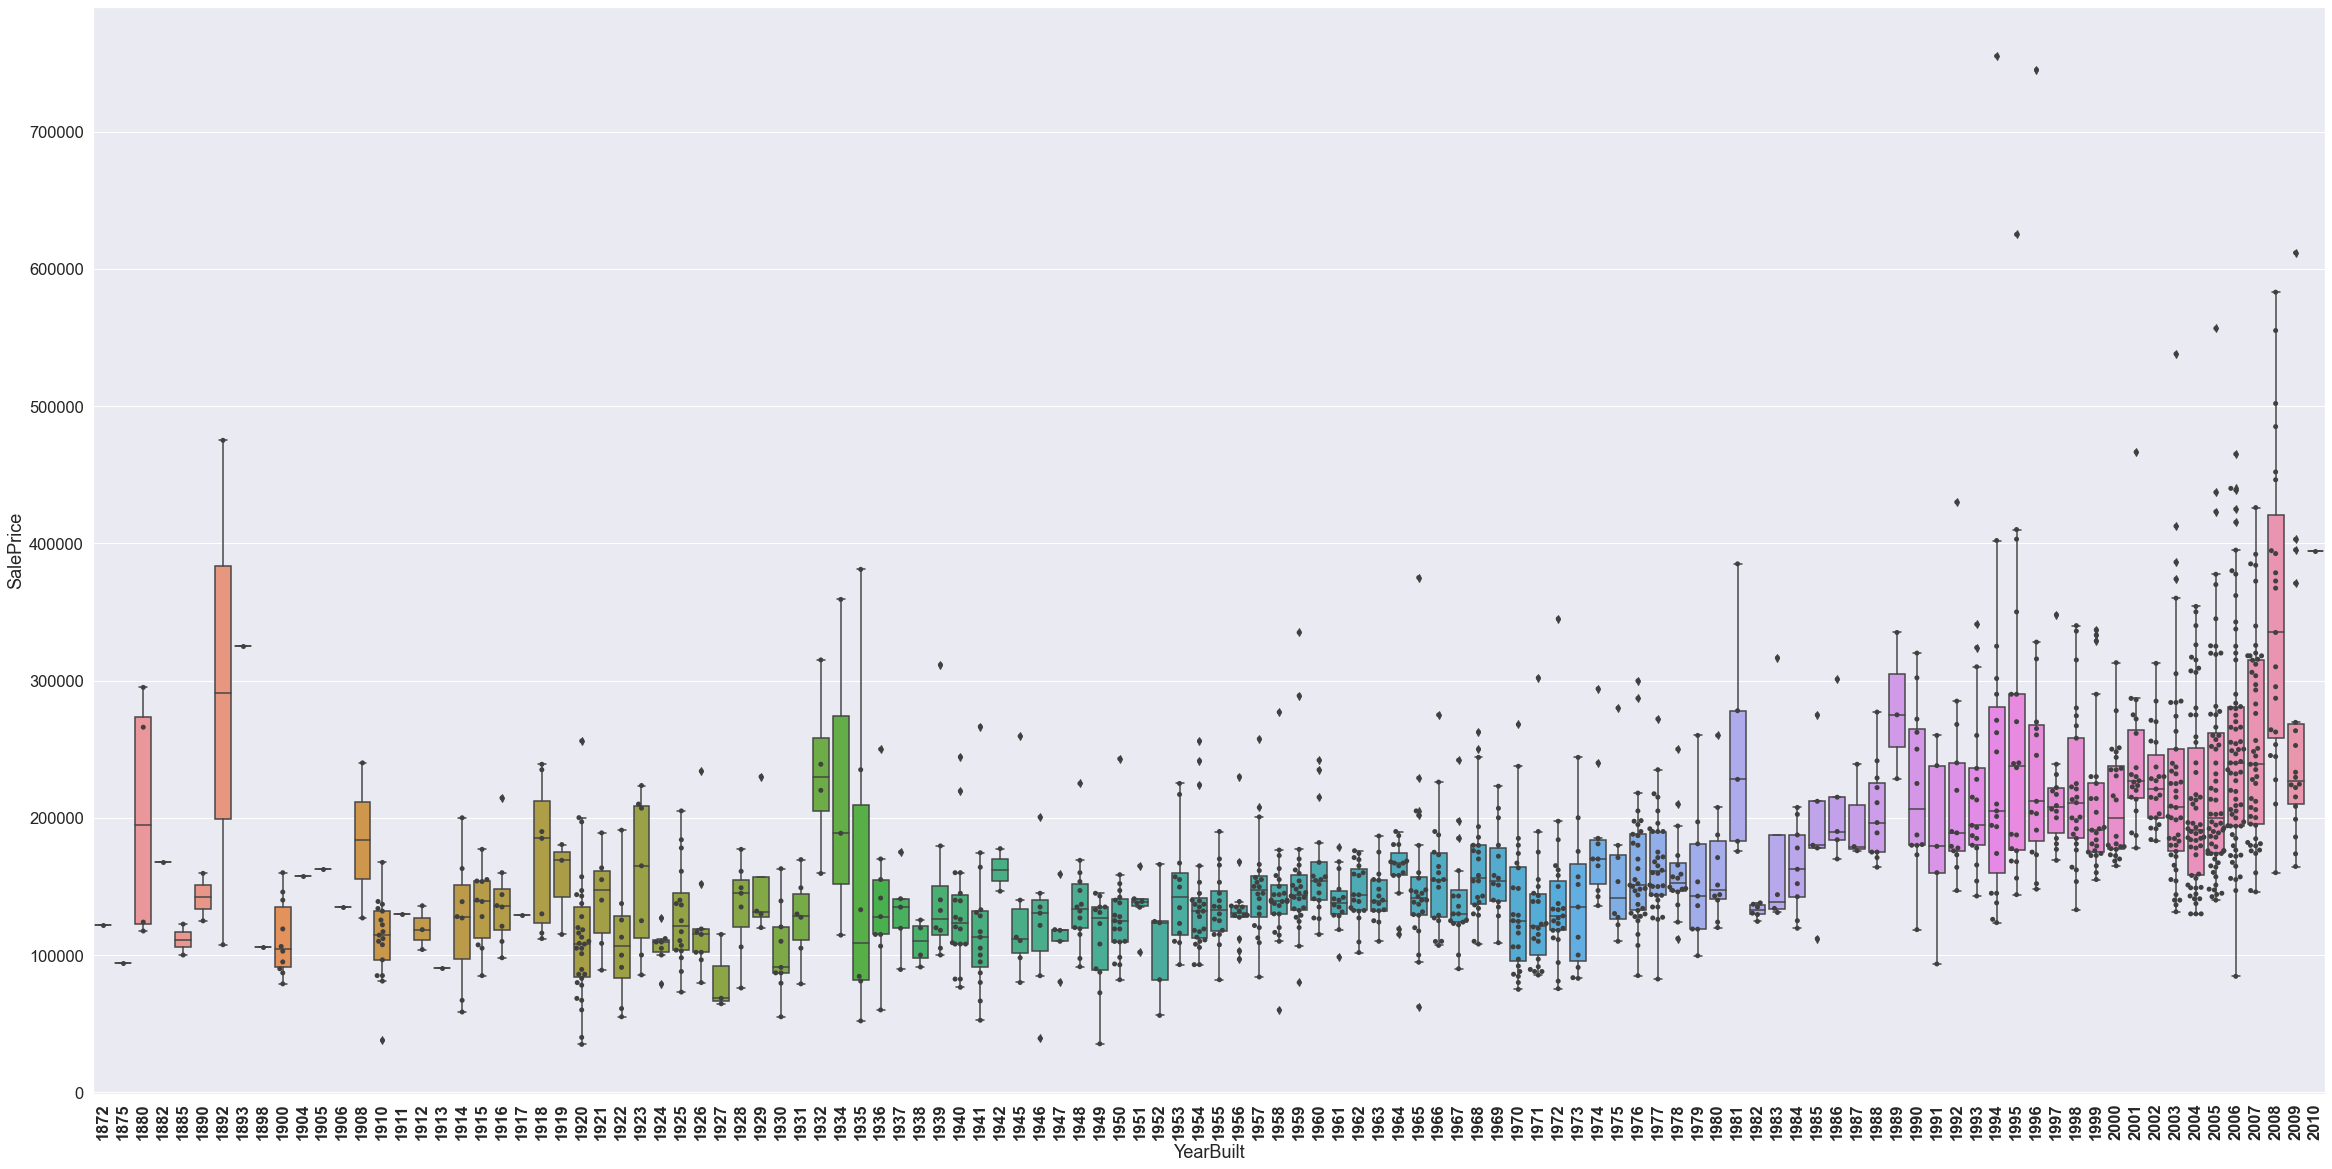

In [5]:
plt.figure(figsize=(40,20))
sb.set(font_scale=1.5)
sb.boxplot(x='YearBuilt', y="SalePrice", data=train)
sb.swarmplot(x='YearBuilt', y="SalePrice", data=train, color=".25")
plt.xticks(weight='bold',rotation=90)


# **Clean and Edit Dataframes**

# We must combine train and test datasets. Because This processes are must be carried out together.

In [6]:
train_test=pd.concat([train,test],axis=0,sort=False)

In [7]:
pd.set_option('display.max_rows', 5000)
train_test_null_info=pd.DataFrame(train_test.isnull().sum(),columns=['Count of NaN'])
train_test_dtype_info=pd.DataFrame(train_test.dtypes,columns=['DataTypes'])
train_tes_info=pd.concat([train_test_null_info,train_test_dtype_info],axis=1)
train_tes_info

Count of NaN DataTypes
Id                        0     int64
MSSubClass                0     int64
MSZoning                  4    object
LotFrontage             486   float64
LotArea                   0     int64
Street                    0    object
Alley                  2721    object
LotShape                  0    object
LandContour               0    object
Utilities                 2    object
LotConfig                 0    object
LandSlope                 0    object
Neighborhood              0    object
Condition1                0    object
Condition2                0    object
BldgType                  0    object
HouseStyle                0    object
OverallQual               0     int64
OverallCond               0     int64
YearBuilt                 0     int64
YearRemodAdd              0     int64
RoofStyle                 0    object
RoofMatl                  0    object
Exterior1st               1    object
Exterior2nd               1    object
MasVnrType               24    object
MasVnrArea               23   float64
ExterQual                 0    object
ExterCond                 0    object
Foundation                0    object
BsmtQual                 81    object
BsmtCond                 82    object
BsmtExposure             82    object
BsmtFinType1             79    object
BsmtFinSF1                1   float64
BsmtFinType2             80    object
BsmtFinSF2                1   float64
BsmtUnfSF                 1   float64
TotalBsmtSF               1   float64
Heating                   0    object
HeatingQC                 0    object
CentralAir                0    object
Electrical                1    object
1stFlrSF                  0     int64
2ndFlrSF                  0     int64
LowQualFinSF              0     int64
GrLivArea                 0     int64
BsmtFullBath              2   float64
BsmtHalfBath              2   float64
FullBath                  0     int64
HalfBath                  0     int64
BedroomAbvGr              0     int64
KitchenAbvGr              0     int64
KitchenQual               1    object
TotRmsAbvGrd              0     int64
Functional                2    object
Fireplaces                0     int64
FireplaceQu            1420    object
GarageType              157    object
GarageYrBlt             159   float64
GarageFinish            159    object
GarageCars                1   float64
GarageArea                1   float64
GarageQual              159    object
GarageCond              159    object
PavedDrive                0    object
WoodDeckSF                0     int64
OpenPorchSF               0     int64
EnclosedPorch             0     int64
3SsnPorch                 0     int64
ScreenPorch               0     int64
PoolArea                  0     int64
PoolQC                 2909    object
Fence                  2348    object
MiscFeature            2814    object
MiscVal                   0     int64
MoSold                    0     int64
YrSold                    0     int64
SaleType                  1    object
SaleCondition             0    object
SalePrice              1459   float64

# Fillna and Feature Engineering

In [8]:
train_test.loc[train_test['Fireplaces']==0,'FireplaceQu']='Nothing'
train_test['LotFrontage'] = train_test['LotFrontage'].fillna(train_test.groupby('1stFlrSF')['LotFrontage'].transform('mean'))
train_test['LotFrontage'].interpolate(method='linear',inplace=True)
train_test['LotFrontage']=train_test['LotFrontage'].astype(int)
train_test['MasVnrArea'] = train_test['MasVnrArea'].fillna(train_test.groupby('MasVnrType')['MasVnrArea'].transform('mean'))
train_test['MasVnrArea'].interpolate(method='linear',inplace=True)
train_test['MasVnrArea']=train_test['MasVnrArea'].astype(int)
train_test["Fence"] = train_test["Fence"].fillna("None")
train_test["FireplaceQu"] = train_test["FireplaceQu"].fillna("None")
train_test["Alley"] = train_test["Alley"].fillna("None")
train_test["PoolQC"] = train_test["PoolQC"].fillna("None")
train_test["MiscFeature"] = train_test["MiscFeature"].fillna("None")
train_test.loc[train_test['BsmtFinSF1']==0,'BsmtFinType1']='Unf'
train_test.loc[train_test['BsmtFinSF2']==0,'BsmtQual']='TA'
train_test['YrBltRmd']=train_test['YearBuilt']+train_test['YearRemodAdd']
train_test['Total_Square_Feet'] = (train_test['BsmtFinSF1'] + train_test['BsmtFinSF2'] + train_test['1stFlrSF'] + train_test['2ndFlrSF'] + train_test['TotalBsmtSF'])
train_test['Total_Bath'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) + train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))
train_test['Total_Porch_Area'] = (train_test['OpenPorchSF'] + train_test['3SsnPorch'] + train_test['EnclosedPorch'] + train_test['ScreenPorch'] + train_test['WoodDeckSF'])
train_test['exists_pool'] = train_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_garage'] = train_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_fireplace'] = train_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_bsmt'] = train_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train_test['old_house'] = train_test['YearBuilt'].apply(lambda x: 1 if x <1990 else 0)

for i in train_test.columns:
    if 'SalePrice' not in i:
        if 'object' in str(train_test[str(i)].dtype):
            train_test[str(i)]=train_test[str(i)].fillna(method='ffill')


In [9]:
columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'YrSold', 'MoSold', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond')

for col in columns:
    lbl_enc = LabelEncoder() 
    lbl_enc.fit(list(train_test[col].values)) 
    train_test[col] = lbl_enc.transform(list(train_test[col].values))

In [10]:
numeric_features = train_test.dtypes[train_test.dtypes != "object"].index
skewed_features = train_test[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
print(skewed_features)

MiscVal              21.947195
PoolArea             16.898328
exists_pool          14.884318
LotArea              12.822431
LowQualFinSF         12.088761
3SsnPorch            11.376065
LandSlope             4.975157
KitchenAbvGr          4.302254
EnclosedPorch         4.003891
ScreenPorch           3.946694
MasVnrArea            2.600375
OpenPorchSF           2.535114
WoodDeckSF            1.842433
LotFrontage           1.483631
1stFlrSF              1.469604
Total_Porch_Area      1.376649
GrLivArea             1.269358
2ndFlrSF              0.861675
TotRmsAbvGrd          0.758367
MSSubClass            0.738722
Fireplaces            0.733495
HalfBath              0.694566
OverallCond           0.570312
HeatingQC             0.486656
FireplaceQu           0.333787
BedroomAbvGr          0.326324
OverallQual           0.197110
MoSold                0.195884
FullBath              0.167606
YrSold                0.132399
Id                    0.000000
exists_fireplace     -0.054148
BsmtFinT

In [11]:
high_skewness = skewed_features[abs(skewed_features) > 0.9]
skewed_features = high_skewness.index

In [12]:
print(high_skewness)
print('\nVariables with high skewness: \n\n',skewed_features)

MiscVal             21.947195
PoolArea            16.898328
exists_pool         14.884318
LotArea             12.822431
LowQualFinSF        12.088761
3SsnPorch           11.376065
LandSlope            4.975157
KitchenAbvGr         4.302254
EnclosedPorch        4.003891
ScreenPorch          3.946694
MasVnrArea           2.600375
OpenPorchSF          2.535114
WoodDeckSF           1.842433
LotFrontage          1.483631
1stFlrSF             1.469604
Total_Porch_Area     1.376649
GrLivArea            1.269358
BsmtExposure        -1.176341
KitchenQual         -1.448023
ExterQual           -1.801409
Fence               -1.993777
ExterCond           -2.497719
PavedDrive          -2.979084
BsmtCond            -3.301446
BsmtFinType2        -3.412861
CentralAir          -3.459022
GarageQual          -3.919880
exists_garage       -3.941054
Functional          -4.055757
GarageCond          -5.147262
exists_bsmt         -5.828995
BsmtQual            -6.303596
Street             -15.500133
PoolQC    

In [13]:
for feature in skewed_features:
    train_test[feature] = boxcox1p(train_test[feature], boxcox_normmax(train_test[feature] + 1))


In [14]:
train_test=pd.get_dummies(train_test,dtype='int8')

In [15]:
train_test_null_info=pd.DataFrame(train_test.isnull().sum(),columns=['Count of NaN'])
train_test_dtype_info=pd.DataFrame(train_test.dtypes,columns=['DataTypes'])
train_test_info=pd.concat([train_test_null_info,train_test_dtype_info],axis=1)
train_test_info

Count of NaN DataTypes
Id                                0     int64
MSSubClass                        0     int64
LotFrontage                       0   float64
LotArea                           0   float64
Street                            0   float64
Alley                             0     int64
LotShape                          0     int64
LandSlope                         0   float64
OverallQual                       0     int64
OverallCond                       0     int64
YearBuilt                         0     int64
YearRemodAdd                      0     int64
MasVnrArea                        0   float64
ExterQual                         0   float64
ExterCond                         0   float64
BsmtQual                          0   float64
BsmtCond                          0   float64
BsmtExposure                      0   float64
BsmtFinType1                      0     int64
BsmtFinSF1                        1   float64
BsmtFinType2                      0   float64
BsmtFinSF2                        1   float64
BsmtUnfSF                         1   float64
TotalBsmtSF                       1   float64
HeatingQC                         0     int64
CentralAir                        0   float64
1stFlrSF                          0   float64
2ndFlrSF                          0     int64
LowQualFinSF                      0   float64
GrLivArea                         0   float64
BsmtFullBath                      2   float64
BsmtHalfBath                      2   float64
FullBath                          0     int64
HalfBath                          0     int64
BedroomAbvGr                      0     int64
KitchenAbvGr                      0   float64
KitchenQual                       0   float64
TotRmsAbvGrd                      0     int64
Functional                        0   float64
Fireplaces                        0     int64
FireplaceQu                       0     int64
GarageYrBlt                     159   float64
GarageFinish                      0     int64
GarageCars                        1   float64
GarageArea                        1   float64
GarageQual                        0   float64
GarageCond                        0   float64
PavedDrive                        0   float64
WoodDeckSF                        0   float64
OpenPorchSF                       0   float64
EnclosedPorch                     0   float64
3SsnPorch                         0   float64
ScreenPorch                       0   float64
PoolArea                          0   float64
PoolQC                            0   float64
Fence                             0   float64
MiscVal                           0   float64
MoSold                            0     int64
YrSold                            0     int64
SalePrice                      1459   float64
YrBltRmd                          0     int64
Total_Square_Feet                 1   float64
Total_Bath                        2   float64
Total_Porch_Area                  0   float64
exists_pool                       0   float64
exists_garage                     0   float64
exists_fireplace                  0     int64
exists_bsmt                       0   float64
old_house                         0     int64
MSZoning_C (all)                  0      int8
MSZoning_FV                       0      int8
MSZoning_RH                       0      int8
MSZoning_RL                       0      int8
MSZoning_RM                       0      int8
LandContour_Bnk                   0      int8
LandContour_HLS                   0      int8
LandContour_Low                   0      int8
LandContour_Lvl                   0      int8
Utilities_AllPub                  0      int8
Utilities_NoSeWa                  0      int8
LotConfig_Corner                  0      int8
LotConfig_CulDSac                 0      int8
LotConfig_FR2                     0      int8
LotConfig_FR3                     0      int8
LotConfig_Inside                  0      int8
Neighborhood_Blmngtn              0      int8
Neighborhood_Blueste 

# It's time to leave

In [16]:
train=train_test[0:1460]
test=train_test[1460:2919]

In [17]:
len(train)

1460

In [18]:
train.interpolate(method='linear',inplace=True)
test.interpolate(method='linear',inplace=True)

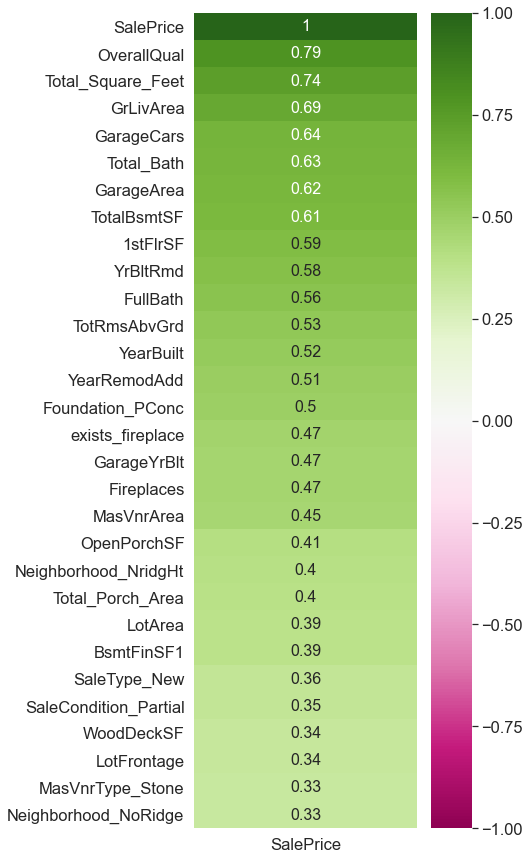

In [19]:
corr_new_train=train.corr()
plt.figure(figsize=(5,15))
sb.heatmap(corr_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
sb.set(font_scale=2)

# These are the columns with the best correlation rate. Let's visualize them.

In [20]:
corr_dict2=corr_new_train['SalePrice'].sort_values(ascending=False).to_dict()
corr_dict2

{'SalePrice': 1.0,
 'OverallQual': 0.7909816005838047,
 'Total_Square_Feet': 0.7378811939482367,
 'GrLivArea': 0.694842798632245,
 'GarageCars': 0.640409197258349,
 'Total_Bath': 0.6317310679319897,
 'GarageArea': 0.6234314389183598,
 'TotalBsmtSF': 0.6135805515591944,
 '1stFlrSF': 0.5885261462134714,
 'YrBltRmd': 0.5761444313502854,
 'FullBath': 0.5606637627484452,
 'TotRmsAbvGrd': 0.5337231555820238,
 'YearBuilt': 0.5228973328794967,
 'YearRemodAdd': 0.5071009671113867,
 'Foundation_PConc': 0.4977337525869438,
 'exists_fireplace': 0.4719080685164922,
 'GarageYrBlt': 0.46729002276453646,
 'Fireplaces': 0.4669288367515242,
 'MasVnrArea': 0.4549307986694866,
 'OpenPorchSF': 0.40653586592794516,
 'Neighborhood_NridgHt': 0.40214859817526666,
 'Total_Porch_Area': 0.3951689425120774,
 'LotArea': 0.3906209688146486,
 'BsmtFinSF1': 0.38641980624215627,
 'SaleType_New': 0.35750940508319695,
 'SaleCondition_Partial': 0.35205985467143425,
 'WoodDeckSF': 0.3376558488487912,
 'LotFrontage': 0.3370

# Columns with more than 40% positive or negative correlations with SalePrice

In [21]:
best_columns=[]
for key,value in corr_dict2.items():
    if ((value>=0.3175) & (value<0.9)) | (value<=-0.315):
        best_columns.append(key)
best_columns

['OverallQual',
 'Total_Square_Feet',
 'GrLivArea',
 'GarageCars',
 'Total_Bath',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'YrBltRmd',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'Foundation_PConc',
 'exists_fireplace',
 'GarageYrBlt',
 'Fireplaces',
 'MasVnrArea',
 'OpenPorchSF',
 'Neighborhood_NridgHt',
 'Total_Porch_Area',
 'LotArea',
 'BsmtFinSF1',
 'SaleType_New',
 'SaleCondition_Partial',
 'WoodDeckSF',
 'LotFrontage',
 'MasVnrType_Stone',
 'Neighborhood_NoRidge',
 '2ndFlrSF',
 'Foundation_CBlock',
 'MasVnrType_None',
 'GarageType_Detchd',
 'HeatingQC',
 'GarageFinish',
 'old_house',
 'KitchenQual',
 'ExterQual']

In [22]:
print(len(best_columns))

38


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38]),
 [Text(1, 0, 'OverallQual'),
  Text(2, 0, 'Total_Square_Feet'),
  Text(3, 0, 'GrLivArea'),
  Text(4, 0, 'GarageCars'),
  Text(5, 0, 'Total_Bath'),
  Text(6, 0, 'GarageArea'),
  Text(7, 0, 'TotalBsmtSF'),
  Text(8, 0, '1stFlrSF'),
  Text(9, 0, 'YrBltRmd'),
  Text(10, 0, 'FullBath'),
  Text(11, 0, 'TotRmsAbvGrd'),
  Text(12, 0, 'YearBuilt'),
  Text(13, 0, 'YearRemodAdd'),
  Text(14, 0, 'Foundation_PConc'),
  Text(15, 0, 'exists_fireplace'),
  Text(16, 0, 'GarageYrBlt'),
  Text(17, 0, 'Fireplaces'),
  Text(18, 0, 'MasVnrArea'),
  Text(19, 0, 'OpenPorchSF'),
  Text(20, 0, 'Neighborhood_NridgHt'),
  Text(21, 0, 'Total_Porch_Area'),
  Text(22, 0, 'LotArea'),
  Text(23, 0, 'BsmtFinSF1'),
  Text(24, 0, 'SaleType_New'),
  Text(25, 0, 'SaleCondition_Partial'),
  Text(26, 0, 'WoodDeckSF'),
  Text(27, 0, 'LotFrontage'),
  

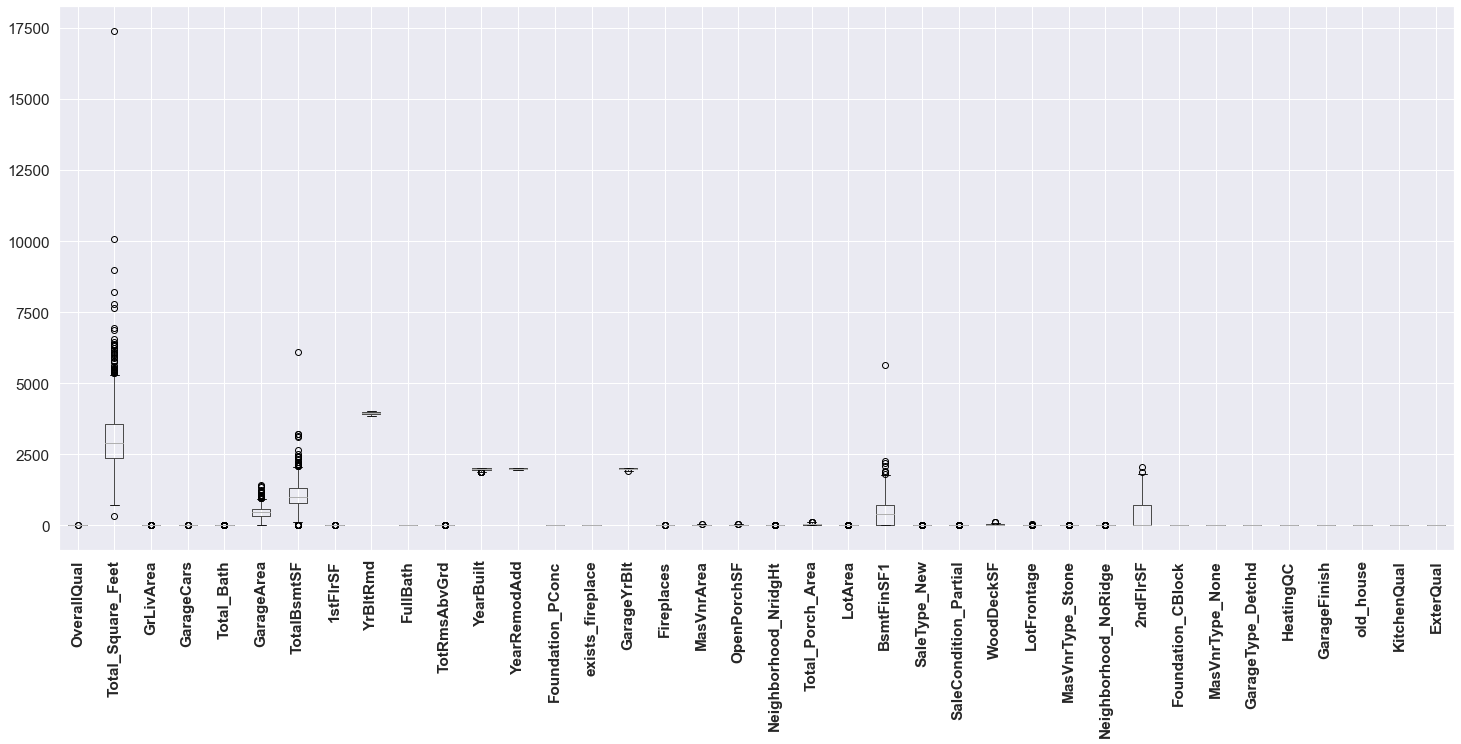

In [23]:
plt.figure(figsize=(25,10))
sb.set(font_scale=1.4)
train.boxplot(column=best_columns)
plt.xticks(weight='bold',rotation=90)


In [24]:
train['SalePrice_Log1p'] = np.log1p(train.SalePrice)

In [25]:
print(len(train[(train.KitchenQual==3) & (train.SalePrice>360000)].index))

0


# With the help of the above visualizations, we detected outliers. Let's get rid!

In [26]:
len(train)

1460

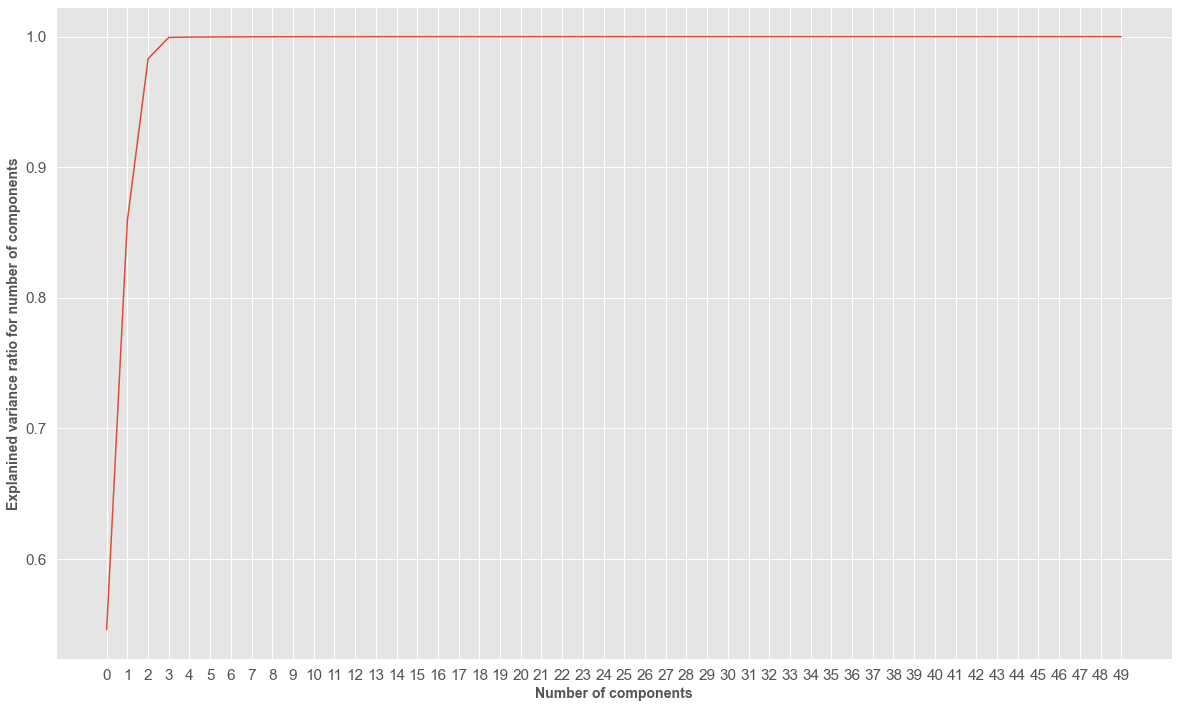

In [27]:
plt.style.use('ggplot')
plt.figure(figsize=(20,12))
rbst_scaler=RobustScaler()
train_rbst=rbst_scaler.fit_transform(train)

pca=PCA(50).fit(train_rbst)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xticks(np.arange(0, 50, 1))
plt.xlabel('Number of components',fontweight='bold',size=14)
plt.ylabel('Explanined variance ratio for number of components',fontweight='bold',size=14)

train_pca=PCA(3).fit_transform(train_rbst)

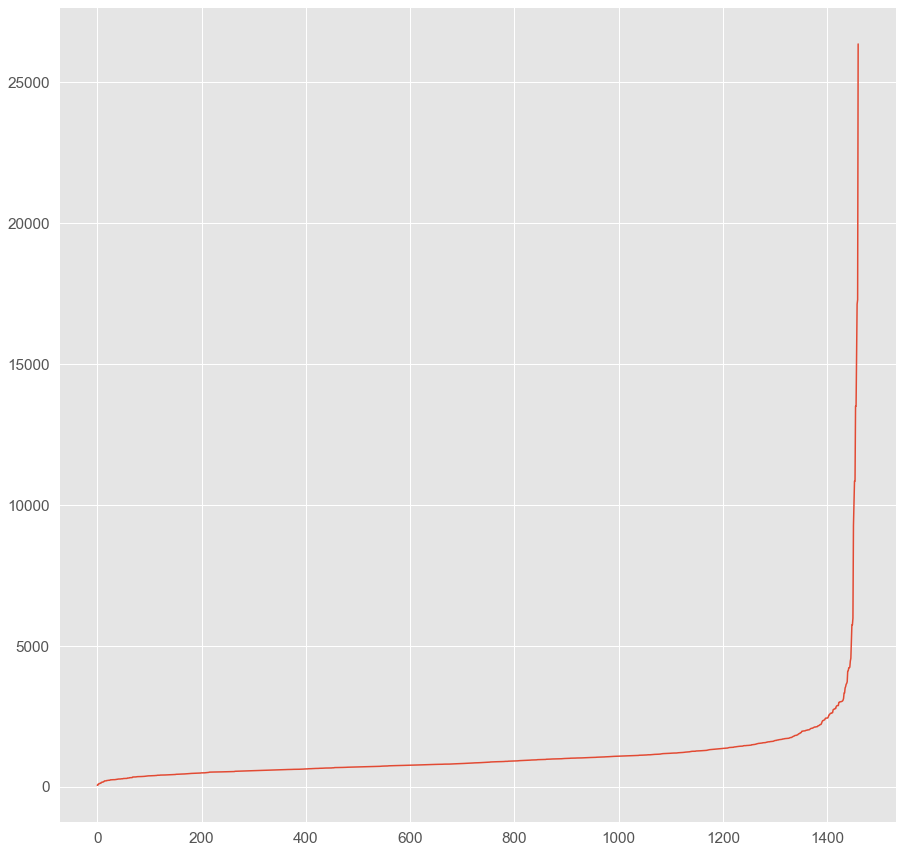

In [28]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(train)
distances, indices = nbrs.kneighbors(train)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(15,15))
plt.plot(distances)

In [29]:
dbscan = DBSCAN(eps=1400, min_samples=20).fit(train_pca)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels=dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

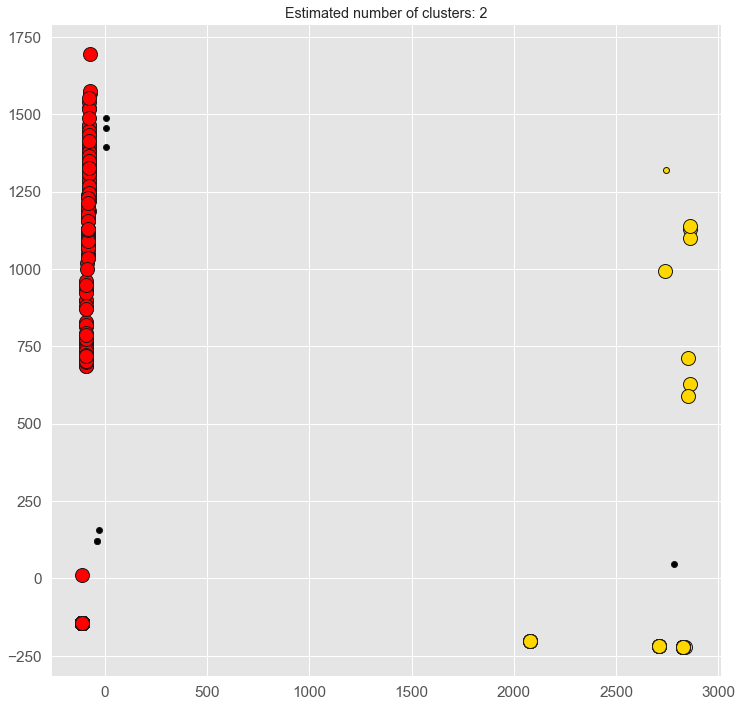

In [30]:
unique_labels = set(labels)
plt.figure(figsize=(12,12))
colors = [plt.cm.prism(each)  for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = train_pca[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = train_pca[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [31]:
labels=pd.DataFrame(labels,columns=['Classes'])
print(labels[labels['Classes']==-1])

      Classes
197        -1
810        -1
1170       -1
1182       -1
1298       -1
1386       -1
1423       -1


In [32]:
train=pd.concat([train,labels],axis=1)

In [33]:
train[train.Classes==-1]

Id  MSSubClass  LotFrontage    LotArea    Street  Alley  LotShape  \
197    198           7    23.181519  15.851263  5.271674      1         3   
810    811           0    15.102190  13.811205  5.271674      1         3   
1170  1171           8    14.890046  13.755758  5.271674      1         3   
1182  1183           5    22.181021  14.751523  5.271674      1         0   
1298  1299           5    31.456866  18.058233  5.271674      1         2   
1386  1387           5    15.311586  14.898481  5.271674      1         0   
1423  1424           8    14.457069  15.268763  5.271674      1         0   

      LandSlope  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
197         0.0            8            3       1918          1990   
810         0.0            6            5       1974          1999   
1170        0.0            6            5       1977          1977   
1182        0.0           10            4       1996          1996   
1298        0.0           10            4       2008          2008   
1386        0.0            7            4       1978          1978   
1423        0.0            6            6       1966          1966   

      MasVnrArea  ExterQual  ExterCond   BsmtQual  BsmtCond  BsmtExposure  \
197     0.000000   5.498766   2.335065  54.556498  5.218987      6.112247   
810    14.086207  11.456359   5.100238  54.556498  5.218987      6.112247   
1170    0.000000  11.456359   5.100238  54.556498  5.218987      0.000000   
1182    0.000000   5.498766   5.100238  54.556498  5.218987      0.000000   
1298   36.986269   0.000000   5.100238  54.556498  5.218987      1.372290   
1386   18.939833  11.456359   5.100238  17.781546  5.218987      6.112247   
1423    0.000000   5.498766   2.335065  54.556498  5.218987      0.000000   

      BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
197              2      1036.0    193.629659       184.0      140.0   
810              0       663.0    193.629659       377.0        0.0   
1170             0       522.0   1444.251693         0.0      574.0   
1182             2      2096.0   1444.251693         0.0      300.0   
1298             2      5644.0   1444.251693         0.0      466.0   
1386             1       790.0    193.629659       469.0      133.0   
1423             5         0.0   1444.251693         0.0      697.0   

      TotalBsmtSF  HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  \
197        1360.0          2   46.910889  5.594620      1360      4.792411   
810        1040.0          1   46.910889  5.572166         0      0.000000   
1170       1096.0          4   46.910889  5.478841         0      0.000000   
1182       2396.0          0   46.910889  5.923584      2065      0.000000   
1298       6110.0          0   46.910889  6.289153       950      0.000000   
1386       1392.0          4   46.910889  5.608253      1392      0.000000   
1423        697.0          4   46.910889  5.680266       626      0.000000   

      GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
197    7.797760           1.0           1.0         2         0             4   
810    6.981778           1.0           0.0         1         1             3   
1170   6.832623           1.0           0.0         1         0             3   
1182   8.138686           1.0           0.0         3         1             4   
1298   8.355353           2.0           0.0         2         1             3   
1386   7.693105           1.0           0.0         3         1             5   
1423   7.472027           0.0           0.0         2         0             4   

      KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  \
197        0.75096     5.077704             8      30.831           1   
810        0.75096     5.077704             5      30.831           1   
1170       0.75096    10.302990             6      30.831           1   
1182       0.75096     0.000000            10      30.831           2   
1298 

In [34]:
train.drop([197,810,1170,1182,1298,1386,1423],axis=0,inplace=True)

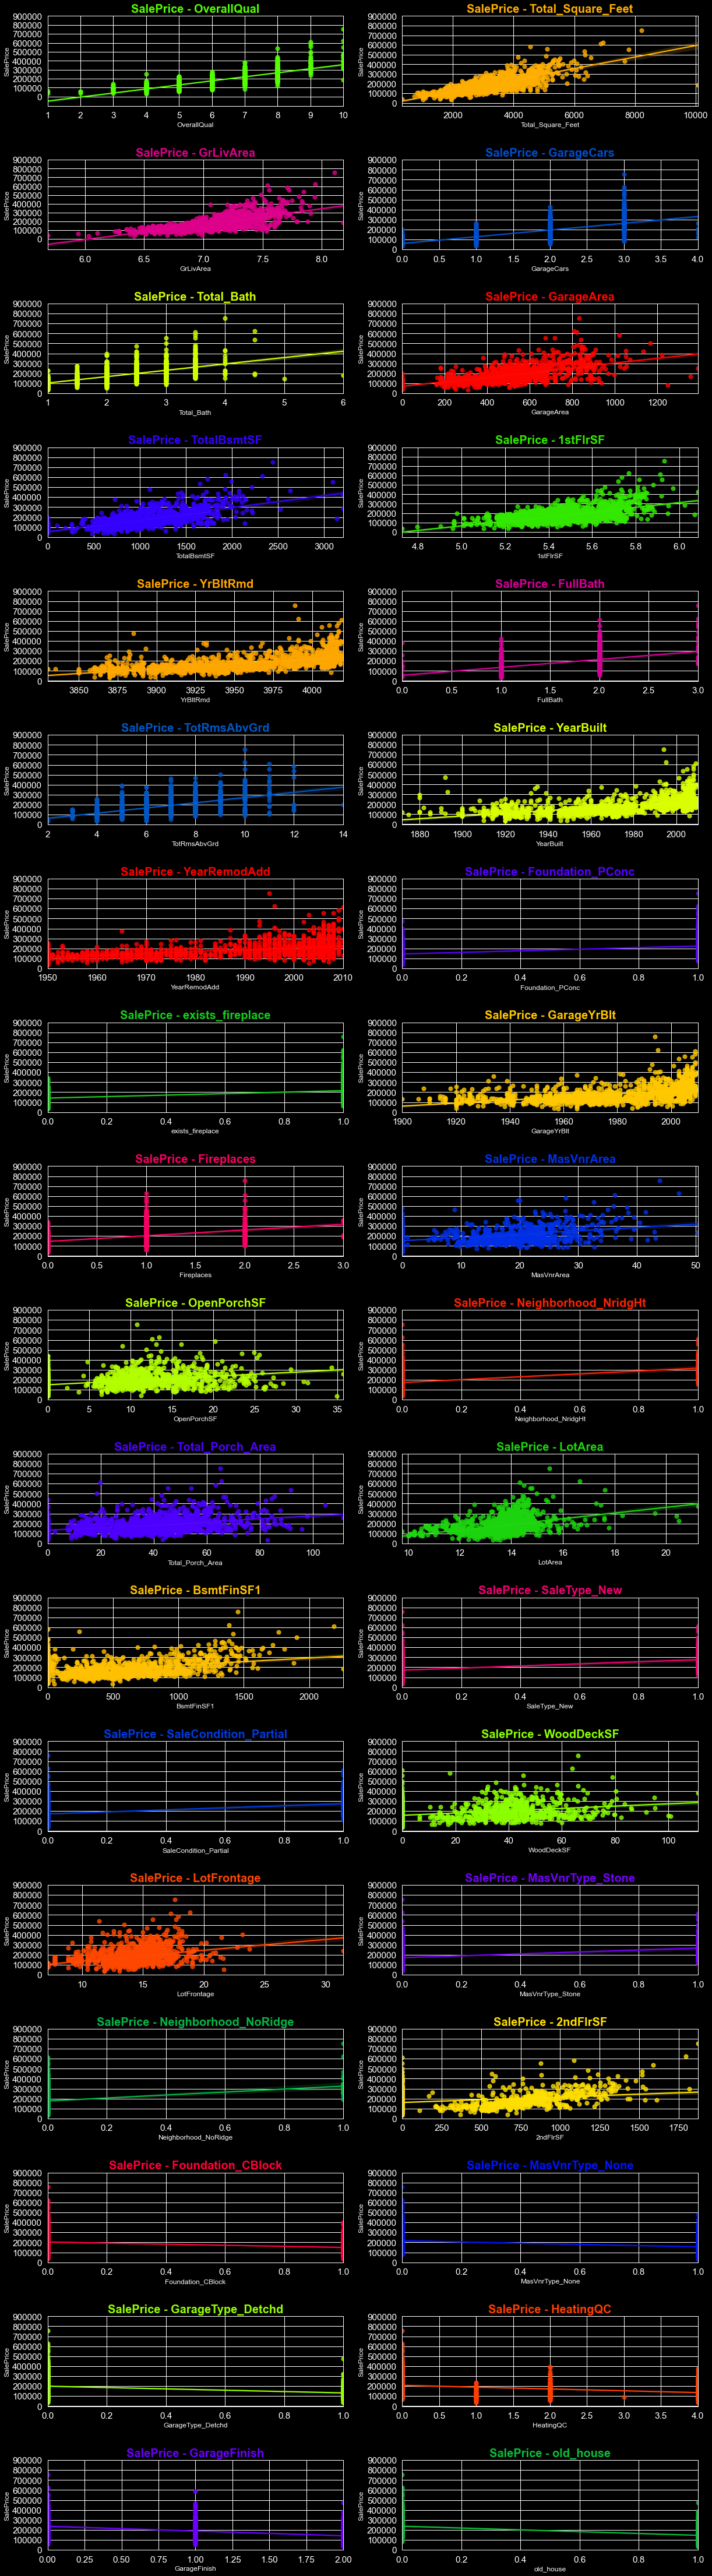

In [35]:
plt.style.use('dark_background')
fig, axes = plt.subplots(18, 2,figsize=(20,80))
fig.subplots_adjust(hspace=0.6)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(best_columns))]
for i,ax,color in zip(best_columns,axes.flatten(),colors):
    sb.regplot(x=train[i], y=train["SalePrice"], fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.8},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice',fontsize=12)
    ax.set_yticks(np.arange(0,900001,100000))
    ax.set_title('SalePrice'+' - '+str(i),color=color,fontweight='bold',size=20)

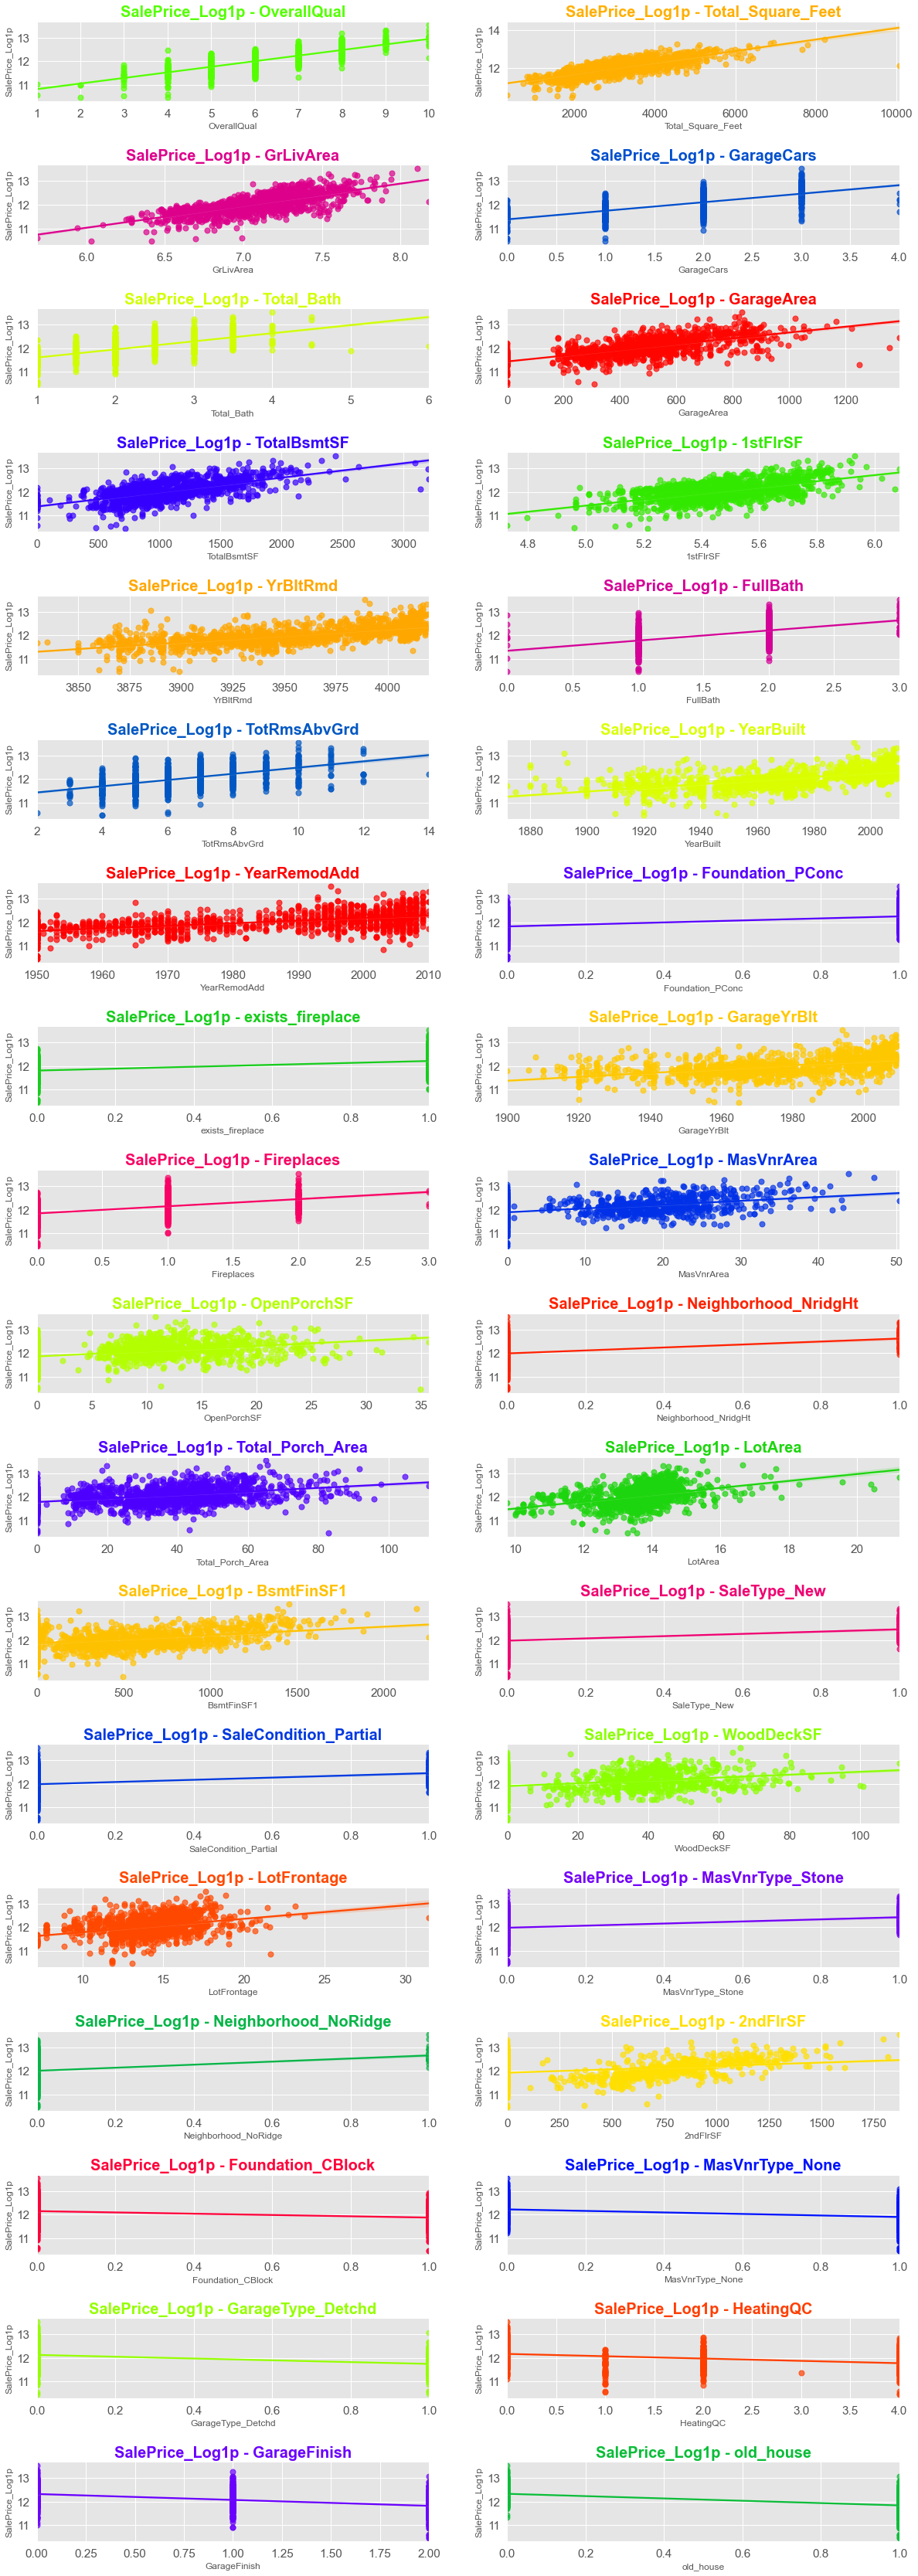

In [36]:
plt.style.use('ggplot')
fig, axes = plt.subplots(18, 2,figsize=(20,60))
fig.subplots_adjust(hspace=0.8)
sb.set(font_scale=1.2)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(best_columns))]
for i,ax,color in zip(best_columns,axes.flatten(),colors):
    sb.regplot(x=train[i], y=train["SalePrice_Log1p"], fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.7},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice_Log1p',fontsize=12)
    ax.set_title('SalePrice_Log1p'+' - '+str(i),color=color,fontweight='bold',size=20)

In [37]:
"Looking at the SalePrice and SalePrice_Log1p visualizations"

#train = train.drop(train[(train.OverallQual==4) & (train.SalePrice>200000)].index)
#train = train.drop(train[(train.OverallQual==10) & (train.SalePrice<200000)].index)
#train = train.drop(train[(train.Total_Square_Feet>=10000) & (train.SalePrice<200000)].index)
#train = train.drop(train[(train.Total_SF<3000) & (train.SalePrice>375000)].index)
#train = train.drop(train[(train.GrLivArea>4500) & (train.SalePrice<200000)].index)
#train = train.drop(train[(train.GrLivArea<3000) & (train.SalePrice>575000)].index)
#train = train.drop(train[(train.GarageArea>1200) & (train.SalePrice<165000)].index)
#train = train.drop(train[(train.Total_Bath.isin([5,6])) & (train.SalePrice<200000)].index)
#train = train.drop(train[(train.TotRmsAbvGrd==10) & (train.SalePrice>700000)].index)
#train = train.drop(train[(train.YearBuilt<1900) & (train.SalePrice>250000)].index)
#train = train.drop(train[(train.YearBuilt>2000) & (train.SalePrice<100000)].index)
#train = train.drop(train[(train.YearRemodAdd<1970) & (train.SalePrice>350000)].index)
#train = train.drop(train[(train.MasVnrArea>=1400) & (train.SalePrice<250000)].index)
#train = train.drop(train[(train.GarageYrBlt<1960) & (train.SalePrice>340000)].index)
#train = train.drop(train[(train.Total_Porch_Area>600) & (train.SalePrice<50000)].index)
#train = train.drop(train[(train.LotFrontage>150) & (train.SalePrice<100000)].index)
#train = train.drop(train[(train.GarageFinish.isin([1,2])) & (train.SalePrice>470000)].index)
#train = train.drop(train[(train.old_house==0) & (train.SalePrice<100000)].index)
#train = train.drop(train[(train.old_house==1) & (train.SalePrice>400000)].index)
#train = train.drop(train[(train.KitchenQual==2) & (train.SalePrice>600000)].index)
#train = train.drop(train[(train.KitchenQual==3) & (train.SalePrice>360000)].index)
#train = train.drop(train[(train.ExterQual==2) & (train.SalePrice>550000)].index)


# train = train[train.GarageArea * train.GarageCars < 3700]
# train = train[(train.FullBath + (train.HalfBath*0.5) + train.BsmtFullBath + (train.BsmtHalfBath*0.5))<5]

In [38]:
len(train)

1447

# Correlations increased after the outliers were removed.

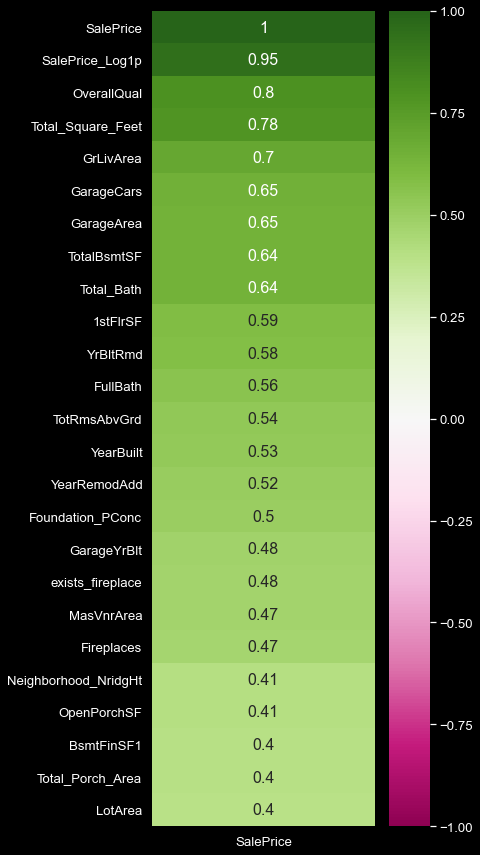

In [39]:
plt.style.use('dark_background')
corr1_new_train=train.corr()
plt.figure(figsize=(5,15))
sb.heatmap(corr1_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(25),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
sb.set(font_scale=2)

# **Create Model**

In [40]:
X=train.drop(['SalePrice','SalePrice_Log1p','Classes'],axis=1)
y=train.SalePrice_Log1p

In [41]:
def overfit_reducer(df):

    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.9:
            overfit.append(i)
    overfit = list(overfit)
    return overfit
overfitted_features = overfit_reducer(X)

In [42]:
test.drop('SalePrice', axis=1, inplace=True)
print(X.shape)
print(test.shape)


(1447, 231)
(1459, 231)


In [43]:
X.drop(overfitted_features,axis=1,inplace=True)
test.drop(overfitted_features,axis=1,inplace=True)
print('X.shape',X.shape)
print('test.shape',test.shape)

X.shape (1447, 211)
test.shape (1459, 211)


In [44]:
std_scaler=StandardScaler()
rbst_scaler=RobustScaler()
power_transformer=PowerTransformer()
X_std=std_scaler.fit_transform(X)
X_rbst=rbst_scaler.fit_transform(X)
X_pwr=power_transformer.fit_transform(X)

test_std=std_scaler.transform(test)
test_rbst=rbst_scaler.transform(test)
test_pwr=power_transformer.transform(test)

In [45]:
X_train,X_test,y_train,y_test=train_test_split(X_std,y,test_size=0.002,random_state=52)
print('X_train Shape :',X_train.shape)
print('X_test Shape :',X_test.shape)
print('y_train Shape :',y_train.shape)
print('y_test Shape :',y_test.shape)

X_train Shape : (1444, 211)
X_test Shape : (3, 211)
y_train Shape : (1444,)
y_test Shape : (3,)


In [105]:
lgb_regressor=lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.035, n_estimators=2177, max_bin=50, bagging_fraction=0.65,bagging_freq=5, bagging_seed=7, 
                                feature_fraction=0.201, feature_fraction_seed=7,n_jobs=-1)
lgb_regressor.fit(X_train, y_train)
y_head=lgb_regressor.predict(X_test)
print('-'*10+'LGBM'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

[LightGBM] [Warning] feature_fraction is set=0.201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.201
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
----------LGBM----------
R square Accuracy:  0.9536338684907038
Mean Absolute Error Accuracy:  0.06399250620753587
Mean Squared Error Accuracy:  0.00499841254410337


In [51]:
gb_reg = GradientBoostingRegressor(n_estimators=1992, learning_rate=0.03005, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=14, loss='huber', random_state =42)
gb_reg.fit(X_train, y_train)
y_head=gb_reg.predict(X_test)
print('-'*10+'GBR'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

----------GBR----------
R square Accuracy:  -0.9416781756689376
Mean Absolute Error Accuracy:  0.1859830162224796
Mean Squared Error Accuracy:  0.05458647002087586


In [50]:
pd.DataFrame(X_train).head()

0         1         2         3         4        5         6    \
0  1.524753 -0.979475 -1.015367  0.304934  0.058885  0.02481 -0.666696   
1 -0.514924 -0.979475  0.327044  0.932422  0.058885  0.02481  0.751993   
2 -0.816482 -0.282671 -0.381079 -0.022032  0.058885  0.02481  0.751993   
3  1.242190 -0.979475  1.087330  0.400157  0.058885  0.02481  0.751993   
4 -1.042058 -0.979475 -0.482008  0.148003  0.058885  0.02481 -1.376040   

        7         8         9         10        11        12        13   \
0 -0.234452  1.384504 -0.519660  1.050325  0.877617  0.903474 -1.042954   
1 -0.234452 -0.797824  1.277110 -0.672715  0.732456  0.324176 -1.042954   
2 -0.234452 -0.070381 -2.316431 -1.434828 -1.686883 -0.748341  0.743491   
3 -0.234452  0.657061 -0.519660 -0.109413 -0.815921 -0.748341 -1.042954   
4 -0.234452 -0.797824 -0.519660 -0.142549 -0.864308 -0.041983  0.743491   

        14        15        16        17        18        19        20   \
0  0.364144 -4.778068  0.289983 -1.869943 -0.977731 -0.155887 -3.240484   
1  0.364144  0.197089  0.289983  0.658945 -0.977731  0.491037 -1.855863   
2  0.364144  0.197089 -3.986029  0.658945  1.200524 -1.010752  0.351625   
3  0.364144  0.197089  0.289983  0.658945 -1.522295  1.449872  0.351625   
4 -2.415061  0.197089  0.289983  0.658945 -0.977731  0.028948  0.351625   

        21        22        23        24        25        26        27   \
0  5.739809 -0.574057  1.450490 -0.881815  0.265078  1.308375 -0.795926   
1  0.829243 -0.884908 -0.104792 -0.881815  0.265078  0.682094 -0.795926   
2 -0.286795  0.490096 -0.641592  1.420370 -3.772477 -1.081031 -0.795926   
3 -0.286795  1.082300  2.536072 -0.881815  0.265078  2.025831 -0.795926   
4 -0.286795 -0.308586 -0.406742  1.420370  0.265078 -0.634460 -0.795926   

        28        29        30        31        32        33        34   \
0 -0.131867  0.471587  1.135237 -0.238997  0.799840 -0.761039  0.173094   
1 -0.131867 -0.141425  1.135237 -0.238997 -1.025662 -0.761039 -1.060731   
2 -0.131867 -1.824634 -0.820344 -0.238997 -1.025662 -0.761039 -1.060731   
3 -0.131867  1.184043  1.135237 -0.238997  0.799840  1.241185  0.173094   
4 -0.131867 -1.404076 -0.820344 -0.238997 -1.025662 -0.761039  0.173094   

        35        36        37        38        39        40        41   \
0 -0.206384 -0.665616  0.932723  0.266934  0.609227  1.642057  1.012929   
1 -0.206384  0.914138 -0.312342 -3.979477  2.169494  1.642057 -1.123582   
2 -0.206384  0.914138 -0.934874  0.266934 -0.951041 -0.076610 -1.164669   
3 -0.206384 -2.200752  0.932723  0.266934  2.169494  1.642057 -0.425107   
4 -0.206384  0.914138 -0.934874  0.266934 -0.951041 -0.076610 -0.342934   

        42        43        44        45        46        47        48   \
0 -1.466656  0.319234  0.151697  0.230035  0.198000  0.297215 -0.855320   
1  1.003951 -1.031443 -0.876880  0.230035  0.198000  0.297215  1.712422   
2  1.003951  0.319234 -0.530817 -4.538630 -5.226448 -3.558000 -0.855320   
3 -1.466656  0.319234  0.247825  0.230035  0.198000  0.297215 -0.855320   
4  1.003951 -1.031443 -0.915332  0.230035  0.198000  0.297215 -0.855320   

        49        50        51        52        53        54        55   \
0  2.343809 -0.397907 -0.128852 -0.287206  0.464458 -0.187270 -0.491800   
1  0.341119 -0.397907 -0.128852  3.196013  0.464458  6.165979 -0.121543   
2 -0.957126  1.937102 -0.128852 -0.287206  0.464458 -0.187270  1.359487   
3 -0.957126 -0.397907 -0.128852 -0.287206  0.464458 -0.187270 -0.862057   
4 -0.957126 -0.397907 -0.128852 -0.287206 -1.587301 -0.187270 -1.602572   

        56        57        58        59        60        61        62   \
0  1.641514  1.092533  1.585061  1.042146  0.657660  0.240309  0.949445   
1  0.888893 -0.113220  0.159197 -0.260087  1.875449  0.240309  0.949445   
2  0.888893 -1.713582 -1.429095 -1.562319 -0.404421  0.240309 -1.053247   
3  1.641514 -0.442061  2.186141  1.693262 -1.510911  0.240309  0.949445   
4  1.641514 -0.485907 -0.783274

In [58]:
from sklearn.model_selection import cross_val_score

def cv_score(model, X, Y, kf):
    lista = (np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv=kf)))
    return sum(lista)/len(lista)

ridgecv_reg3 = make_pipeline( RidgeCV(alphas=alphas, cv=kfolds))
cv_score(ridgecv_reg3, X_train, y_train, kfolds)

# kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# alphas=[1e-9,1e-8,1e-7,1e-6,]

# ridgecv_reg= make_pipeline(RidgeCV(alphas=alphas, cv=kfolds))
# ridgecv_reg.fit(X_train, y_train)
# y_head=ridgecv_reg.predict(X_test)
# print('-'*10+'RidgeCV'+'-'*10)
# print('R square Accuracy: ',r2_score(y_test,y_head))
# print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
# print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

0.12619305051337068

In [ ]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

lassocv_reg= make_pipeline(LassoCV(alphas=alphas, cv=kfolds))
lassocv_reg.fit(X_train, y_train)
y_head=lassocv_reg.predict(X_test)
print('-'*10+'LassoCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006]
l1ratio=[0.87, 0.9,0.92, 0.95,0.97, 0.99, 1]

elasticv_reg= make_pipeline(ElasticNetCV(alphas=alphas, cv=kfolds, l1_ratio=l1ratio))
elasticv_reg.fit(X_train, y_train)
y_head=elasticv_reg.predict(X_test)
print('-'*10+'ElasticNetCV'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
estimators = [('lgbm', lgb_regressor),
              ('gbr', gb_reg),   
              ('lasso', lassocv_reg),   
              ('ridge', ridgecv_reg),   
              ('elasticnet', elasticv_reg)]

stack_reg=StackingRegressor(estimators=estimators,final_estimator=ExtraTreesRegressor(n_estimators=50),n_jobs=-1)
stack_reg.fit(X_train, y_train)
y_head=stack_reg.predict(X_test)
print('-'*10+'StackingRegressor'+'-'*10)
print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

In [ ]:
y_head=pd.DataFrame(y_head,columns=['Predict'])
y_test.reset_index(drop=True,inplace=True)
y_test_y_head=pd.concat([y_test,y_head],axis=1)
y_test_y_head.head()

In [ ]:
print('Count columns of test: ',len(test.columns))
print('Count columns of X: ',len(X.columns))

In [ ]:
test_pred_lgb=lgb_regressor.predict(test_pwr)
test_pred_gb=gb_reg.predict(test_pwr)
test_pred_elastic=elasticv_reg.predict(test_pwr)
test_pred_ridge=ridgecv_reg.predict(test_pwr)
test_pred_lasso=lassocv_reg.predict(test_pwr)
test_pred_stack=stack_reg.predict(test_pwr)

In [ ]:
test_pred_lgb=pd.DataFrame(test_pred_lgb,columns=['SalePrice'])
test_pred_gb=pd.DataFrame(test_pred_gb,columns=['SalePrice'])
test_pred_elastic=pd.DataFrame(test_pred_elastic,columns=['SalePrice'])
test_pred_ridge=pd.DataFrame(test_pred_ridge,columns=['SalePrice'])
test_pred_lasso=pd.DataFrame(test_pred_lasso,columns=['SalePrice'])
test_pred_stack=pd.DataFrame(test_pred_stack,columns=['SalePrice'])

In [ ]:
test_pred_lgb.SalePrice =np.floor(np.expm1(test_pred_lgb.SalePrice))
test_pred_gb.SalePrice =np.floor(np.expm1(test_pred_gb.SalePrice))
test_pred_elastic.SalePrice =np.floor(np.expm1(test_pred_elastic.SalePrice))
test_pred_ridge.SalePrice =np.floor(np.expm1(test_pred_ridge.SalePrice))
test_pred_lasso.SalePrice =np.floor(np.expm1(test_pred_lasso.SalePrice))
test_pred_stack.SalePrice =np.floor(np.expm1(test_pred_stack.SalePrice))

In [ ]:
test_pred_lgb.head()

In [ ]:
test_pred_gb.head()

In [ ]:
test_pred_elastic.head()

In [ ]:
test_pred_ridge.head()

In [ ]:
test_pred_lasso.head()

In [ ]:
test_pred_stack.head()

In [ ]:
final_pred=(test_pred_stack*0.1665)+(test_pred_lgb*0.678)+(test_pred_ridge*0.1665)
final_pred.head()

In [ ]:
sample_sub['SalePrice']=final_pred

In [ ]:
sample_sub.head()

In [ ]:
sample_sub.to_csv('SampleSubmissionForHousePrice.csv',index=False)